In [1]:
import h5py
import torch
import numpy as np

# Build a neural net that takes in 1024 dim vectors and outputs 1024 dim vectors
import torch.nn as nn
import torch.nn.functional as F


class EmbeddingMapper(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1024, hidden_dim=256):  # Reduced from 512
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.final = nn.Linear(128, output_dim)
        self.residual_scale = nn.Parameter(torch.tensor(0.01))
        # self.dropout = nn.Dropout(0.5)

        # nn.init.xavier_uniform_(self.fc3.weight, gain=0.1)
        nn.init.xavier_uniform_(self.fc1.weight, gain=0.1)
        nn.init.xavier_uniform_(self.final.weight, gain=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.final.bias)

    def forward(self, x):
        y = F.tanh(self.fc1(x))
        y = F.tanh(self.final(y))
        y = x + self.residual_scale * y  # Residual connection

        y = F.normalize(y, p=2, dim=1)
        return y


device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model = EmbeddingMapper(input_dim=1024, output_dim=1024).to(device)

# L1 regularization
# L1_lambda = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

triplet_loss = nn.TripletMarginWithDistanceLoss(
    margin=0.1,
    distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y),
)

cosine_loss = nn.CosineEmbeddingLoss(margin=0.1)

loss_function = lambda a, p, n: cosine_loss(a, p, torch.ones(a.size(0)).to(device))


In [2]:
from torch.utils.data import DataLoader, Dataset


# --- Example dataset ---
class TripletDataset(Dataset):
    def __init__(self, h5_path: str):
        with h5py.File(h5_path, "r") as f:
            self.triplets = torch.from_numpy(f["triplets"][:]).float()

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor = self.triplets[idx, 0, :]
        positive = self.triplets[idx, 1, :]
        negative = self.triplets[idx, 2, :]
        return anchor, positive, negative


train_dataset = TripletDataset("../src/citeline/nn/np_vectors_train_triplets.h5")
val_dataset = TripletDataset("../src/citeline/nn/np_vectors_val_triplets.h5")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check initial similarities in the raw data
ap_distances = []
an_distances = []
for anchor, pos, neg in val_dataset:
    ap_dist = 1 - F.cosine_similarity(anchor.unsqueeze(0), pos.unsqueeze(0)).item()
    an_dist = 1 - F.cosine_similarity(anchor.unsqueeze(0), neg.unsqueeze(0)).item()
    ap_distances.append(ap_dist)
    an_distances.append(an_dist)

print(f"=== RAW ===")
print(f"Average Anchor-Positive distance: {np.mean(ap_distances):.4f} ± {np.std(ap_distances):.4f}")
print(f"Average Anchor-Negative distance: {np.mean(an_distances):.4f} ± {np.std(an_distances):.4f}")
print(f"Average margin in raw data: {np.mean(an_distances) - np.mean(ap_distances):.4f}")

Train dataset size: 52668
Validation dataset size: 11088
=== RAW ===
Average Anchor-Positive distance: 0.3744 ± 0.0970
Average Anchor-Negative distance: 0.3260 ± 0.0607
Average margin in raw data: -0.0484


In [3]:
# Baseline loss
with torch.no_grad():
    model.eval()
    val_losses = []
    for anchors, positives, negatives in val_dataloader:
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        anchor_out = model(anchors)
        val_loss = triplet_loss(anchor_out, positives, negatives)
        val_losses.append(val_loss.item())
baseline_val_loss = np.mean(val_losses)
print(f"Baseline validation loss (no training): {baseline_val_loss:.4f}")
# Check if the model is mapping anchors closer to positives
model.eval()
for name, dataset in [("Validation", val_dataset)]:
    ap_distances_after = []
    an_distances_after = []

    with torch.no_grad():
        for anchor, pos, neg in list(dataset)[:1000]:
            anchor = anchor.to(device).unsqueeze(0)

            anchor_emb = model(anchor)  # Only transform anchor

            # Compare to raw positive/negative (no transformation)
            ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
            an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

            ap_distances_after.append(ap_dist)
            an_distances_after.append(an_dist)

    print(f"=== BEFORE TRAINING ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
    print(f"Anchor-Positive distance: {np.mean(ap_distances_after):.4f}")
    print(f"Anchor-Negative distance: {np.mean(an_distances_after):.4f}")
    print(f"Average margin: {np.mean(an_distances_after) - np.mean(ap_distances_after):.4f}")

Baseline validation loss (no training): 0.1495
=== BEFORE TRAINING (Validation set, Anchor mapped, Pos/Neg unchanged) ===
Anchor-Positive distance: 0.3826
Anchor-Negative distance: 0.3313
Average margin: -0.0513


In [ ]:
train_loss_history = []
val_loss_history = []
pos_dist_weight = 1.0
NUM_EPOCHS = 20
min_val_loss = float("inf")
for epoch in range(NUM_EPOCHS):
    # ---- Training ----
    model.train()
    train_losses = []
    for batch_idx, (anchors, positives, negatives) in enumerate(train_dataloader):
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        optimizer.zero_grad()
        anchor_out = model(anchors)

        loss = loss_function(anchor_out, positives, negatives) + (epoch/NUM_EPOCHS) * triplet_loss(anchor_out, positives, negatives)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss_epoch = np.mean(train_losses)
    train_loss_history.append(train_loss_epoch)

    # ---- Validation ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for anchors, positives, negatives in val_dataloader:
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            anchor_out = model(anchors)

            loss = loss_function(anchor_out, positives, negatives) + (epoch/NUM_EPOCHS) * triplet_loss(anchor_out, positives, negatives)

            val_losses.append(loss.item())

    val_loss_epoch = np.mean(val_losses)
    val_loss_history.append(val_loss_epoch)
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch}: Train Loss = {train_loss_epoch:.4f}, Val Loss = {val_loss_epoch:.4f}")

Epoch 0: Train Loss = 0.3196, Val Loss = 0.3058
Epoch 1: Train Loss = 0.3008, Val Loss = 0.2931
Epoch 2: Train Loss = 0.2932, Val Loss = 0.2898
Epoch 3: Train Loss = 0.2897, Val Loss = 0.2874
Epoch 4: Train Loss = 0.2868, Val Loss = 0.2856
Epoch 5: Train Loss = 0.2844, Val Loss = 0.2842
Epoch 6: Train Loss = 0.2823, Val Loss = 0.2831
Epoch 7: Train Loss = 0.2805, Val Loss = 0.2823
Epoch 8: Train Loss = 0.2790, Val Loss = 0.2817
Epoch 9: Train Loss = 0.2777, Val Loss = 0.2813
Epoch 10: Train Loss = 0.2764, Val Loss = 0.2808
Epoch 11: Train Loss = 0.2753, Val Loss = 0.2805
Epoch 12: Train Loss = 0.2743, Val Loss = 0.2803
Epoch 13: Train Loss = 0.2735, Val Loss = 0.2802
Epoch 14: Train Loss = 0.2726, Val Loss = 0.2799
Epoch 15: Train Loss = 0.2719, Val Loss = 0.2799
Epoch 16: Train Loss = 0.2712, Val Loss = 0.2800
Epoch 17: Train Loss = 0.2705, Val Loss = 0.2798
Epoch 18: Train Loss = 0.2699, Val Loss = 0.2797
Epoch 19: Train Loss = 0.2693, Val Loss = 0.2797


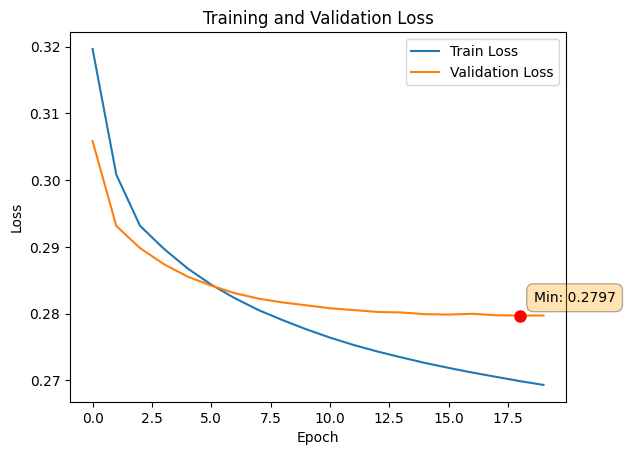

In [5]:
# Plot train and validation loss
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Add a notation where the minimal val loss occurred and amount
min_val_loss = min(val_loss_history)
min_val_loss_epoch = val_loss_history.index(min_val_loss)

# Mark the point
plt.plot(min_val_loss_epoch, min_val_loss, "ro", markersize=8)

# Add annotation with box
plt.annotate(
    f"Min: {min_val_loss:.4f}",
    xy=(min_val_loss_epoch, min_val_loss),
    xytext=(10, 10),  # Offset in points
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="orange", alpha=0.3),
    # arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
)

plt.title("Training and Validation Loss")
plt.show()

In [6]:
loss_reduction = 1 - (min_val_loss / baseline_val_loss)
print(f"Best loss reduction: {loss_reduction*100:.2f}%")

Best loss reduction: -87.05%


In [7]:
# Check if the model is mapping anchors closer to positives
model.eval()
for name, dataset in [("Validation", val_dataset)]:
    ap_distances_after = []
    an_distances_after = []
    margins = []

    with torch.no_grad():
        for anchor, pos, neg in list(dataset)[:1000]:
            anchor = anchor.to(device).unsqueeze(0)

            anchor_emb = model(anchor)  # Only transform anchor

            # Compare to raw positive/negative (no transformation)
            ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
            an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

            ap_distances_after.append(ap_dist)
            an_distances_after.append(an_dist)
            margins.append(an_dist - ap_dist)

    print(f"=== AFTER TRAINING ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
    print(f"Anchor-Positive distance: {np.mean(ap_distances_after):.4f}")
    print(f"Anchor-Negative distance: {np.mean(an_distances_after):.4f}")
    print(f"Learned margin mean: {np.mean(margins):.4f}")
    print(f"Learned margin median: {np.median(margins):.4f}")
    print(f"Stddev of learned margin: {np.std(margins):.4f}")
    print(f"Distribution of margins: min={np.min(margins):.4f}, max={np.max(margins):.4f}")

=== AFTER TRAINING (Validation set, Anchor mapped, Pos/Neg unchanged) ===
Anchor-Positive distance: 0.2849
Anchor-Negative distance: 0.2578
Learned margin mean: -0.0270
Learned margin median: -0.0231
Stddev of learned margin: 0.0573
Distribution of margins: min=-0.2246, max=0.1910


In [8]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on test set
test_dataset = TripletDataset("../src/citeline/nn/np_vectors_test_triplets.h5")
model.eval()
for name, dataset in [("Test", test_dataset)]:
    ap_distances_after = []
    an_distances_after = []

    with torch.no_grad():
        for anchor, pos, neg in list(dataset)[:1000]:
            anchor = anchor.to(device).unsqueeze(0)

            anchor_emb = model(anchor)  # Only transform anchor

            # Compare to raw positive/negative (no transformation)
            ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
            an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

            ap_distances_after.append(ap_dist)
            an_distances_after.append(an_dist)

    print(f"=== AFTER TRAINING ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
    print(f"Anchor-Positive distance: {np.mean(ap_distances_after):.4f}")
    print(f"Anchor-Negative distance: {np.mean(an_distances_after):.4f}")
    print(f"Learned margin: {np.mean(an_distances_after) - np.mean(ap_distances_after):.4f}")

/var/folders/br/rmys_1r571qbwgg30gx_x2l40000gn/T/ipykernel_59359/2602500826.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.

=== AFTER TRAINING (Test set, Anchor mapped, Pos/Neg unchanged) ===
Anchor-Positive distance: 0.2704
Anchor-Negative distance: 0.2473
Learned margin: -0.0231


In [9]:
# Save entire model
torch.save(model, "best_model_full.pth")

# Save a trace
example_input = torch.randn(1, 1024).to(device)

# Trace the model
trace = torch.jit.trace(model, example_input)
torch.jit.save(trace, "best_model_traced.pth")